In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local") \
    .appName("dataframe03") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [2]:

df = spark.read.parquet("../data/kickstarter.parquet/")

In [7]:
df.show(vertical=True, truncate=False)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 project_id        | kkst2105441663                                                                                                                                                                                                                                                                                                                                                                                             

In [8]:
df.printSchema()

root
 |-- project_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- goal: double (nullable = true)
 |-- keywords: string (nullable = true)
 |-- final_status: integer (nullable = true)
 |-- country_clean: string (nullable = true)
 |-- currency_clean: string (nullable = true)
 |-- deadline_clean: date (nullable = true)
 |-- created_at_clean: date (nullable = true)
 |-- launched_at_clean: date (nullable = true)
 |-- days_campaign: integer (nullable = true)
 |-- hours_prepa: double (nullable = true)



In [28]:
# select some feature to modeling ml
new_df = df.select('goal','country_clean','currency_clean','days_campaign','hours_prepa','final_status')

In [4]:
new_df.show(5)

+------+-------------+--------------+-------------+-----------+------------+
|  goal|country_clean|currency_clean|days_campaign|hours_prepa|final_status|
+------+-------------+--------------+-------------+-----------+------------+
| 750.0|           US|           USD|           45|      29.69|           0|
|2500.0|           US|           USD|           30|      62.02|           1|
|2500.0|           US|           USD|           30|      143.8|           0|
|1869.0|           US|           USD|           40|       1.99|           0|
|5000.0|           US|           USD|           91|     134.81|           0|
+------+-------------+--------------+-------------+-----------+------------+
only showing top 5 rows



In [29]:
# 
new_df = new_df.withColumnRenamed('final_status', 'label')

107615


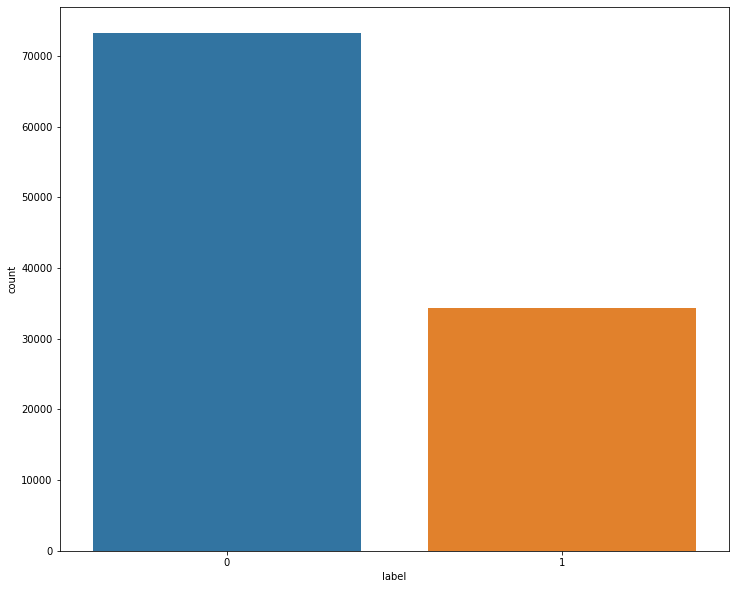

In [13]:
# let's have a look at the distribution of our target variable:
# to make it look better, we first convert our spark df to a Pandasimport matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
df_pd = new_df.toPandas()
print(len(df_pd))
plt.figure(figsize=(12,10))
sns.countplot(x='label', data=df_pd, order=df_pd['label'].value_counts().index)

In [25]:
# now let's see how many categorical and numerical features we have:
cat_cols = [item[0] for item in new_df.dtypes if item[1].startswith('string')]

num_cols = ['days_campaign', 'hours_prepa', 'goal']

In [24]:
num_cols

['days_campaign', 'hours_prepa', 'goal', 'label']

In [31]:
### Features Engineering

In [30]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

stages = []
for categoricalCol in cat_cols:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])

    stages += [stringIndexer, encoder]

assemblerInputs = [c + "classVec" for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [31]:
# we use a pipeline to apply all the stages of transformation
from pyspark.ml import Pipeline

cols = new_df.columns

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(new_df)
new_df = pipelineModel.transform(new_df)
selectedCols = ['features']+cols
new_df = new_df.select(selectedCols)

In [10]:
new_df.show()

+--------------------+--------+-------------+--------------+-------------+-----------+-----+
|            features|    goal|country_clean|currency_clean|days_campaign|hours_prepa|label|
+--------------------+--------+-------------+--------------+-------------+-----------+-----+
|(22,[0,10,18,19,2...|   750.0|           US|           USD|           45|      29.69|    0|
|(22,[0,10,18,19,2...|  2500.0|           US|           USD|           30|      62.02|    1|
|(22,[0,10,18,19,2...|  2500.0|           US|           USD|           30|      143.8|    0|
|(22,[0,10,18,19,2...|  1869.0|           US|           USD|           40|       1.99|    0|
|(22,[0,10,18,19,2...|  5000.0|           US|           USD|           91|     134.81|    0|
|(22,[0,10,18,19,2...|100000.0|           US|           USD|           30|      91.77|    0|
|(22,[0,10,18,19,2...| 15000.0|           US|           USD|           39|     222.65|    1|
|(22,[0,10,18,19,2...| 18000.0|           US|           USD|          

In [32]:
# split the data into trainign and testin sets

train, test = new_df.randomSplit([0.80, 0.20], seed = 12345)
print(train.count())
print(test.count())# first we check how LogisticRegression perform 
from pyspark.ml.classification import RandomForestClassifier
#LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=15)
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
spark_LR_model = rf.fit(train)

85915
21700


In [33]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
predictions_LR = spark_LR_model.transform(test)
pred = spark_LR_model.transform(train)
evaluator = BinaryClassificationEvaluator()

test_auc = evaluator.evaluate(predictions_LR, {evaluator.metricName: "areaUnderROC"})
train_auc = evaluator.evaluate(pred, {evaluator.metricName: "areaUnderROC"})
print("Test_SET (Area Under ROC): " + str(test_auc))

Test_SET (Area Under ROC): 0.6486771317356379


In [13]:
predictions_LR.show()

+--------------------+-------+-------------+--------------+-------------+-----------+-----+--------------------+--------------------+----------+
|            features|   goal|country_clean|currency_clean|days_campaign|hours_prepa|label|       rawPrediction|         probability|prediction|
+--------------------+-------+-------------+--------------+-------------+-----------+-----+--------------------+--------------------+----------+
|(22,[0,10,18,19,2...| 1200.0|           US|           USD|            1|      28.54|    0|[9.94532124403596...|[0.99995205083613...|       0.0|
|(22,[0,10,18,19,2...|25000.0|           US|           USD|            1|     502.54|    0|[9.94617011738390...|[0.99995209151967...|       0.0|
|(22,[0,10,18,19,2...|  800.0|           US|           USD|            1|     634.76|    0|[9.94041263344247...|[0.99995181490512...|       0.0|
|(22,[0,10,18,19,2...|  300.0|           US|           USD|            3|       0.94|    0|[10.0199711569426...|[0.99995549974587.

In [21]:
import mlflow.spark
from mlflow import log_param
from mlflow.tracking import MlflowClient
#from google.cloud import storage

ModuleNotFoundError: No module named 'google.cloud'

In [34]:
#from google.cloud import storage
#experiment_id = create_experiment(experiment_name='sparkml')

mlflow.set_tracking_uri("http://35.246.84.226")
mlflow.set_experiment("kickstarter")
with mlflow.start_run(nested=True):
    
    
    #Now your can log the params and metrics of your model
    mlflow.log_param('max_iter',15)
    mlflow.log_param('model_class','LogisticRegression')
    mlflow.log_metric('test_auc',test_auc)
    mlflow.log_metric('train_auc',train_auc)
    
    #Log your scikit learn model
    mlflow.spark.log_model(spark_LR_model,artifact_path="spark_model")
        

In [ ]:
mlflow.spark.load_model()